# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Project Motivation

My Motivation on this project is to predict the best offers that sent to individual customer by using demographic of customers and engineering features which are insight of the customer bahaviors in transript dataset.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
from time import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
%matplotlib inline



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Exploration

First, we explore the datasets including checking the missing value, duplicatiion, etc. Therefore, we could have a better understanding on how the data really looks like before creating a prediction model.

## 1.1 Portfolio Dataset

In [2]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [5]:
portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio.groupby('offer_type')['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

So there are 3 types of offers: 
    BOGO, Discount and Informational

Channel columns could be categorized as binary input on how users get on the platform.

In [6]:
mkt_channels = portfolio['channels'].str.join(',').str.get_dummies(',')
portfolio_temp = pd.concat([portfolio, mkt_channels], axis = 1)
portfolio_temp.drop(['channels'], axis = 1, inplace = True)

C:\Users\Phongsapon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


<AxesSubplot:xlabel='offer_type'>

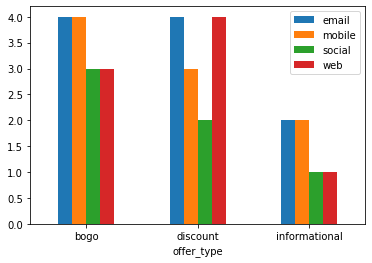

In [7]:
# distribution of channels for diff offers
portfolio_temp.groupby('offer_type')['email','mobile','social','web'].sum().plot.bar(rot= 0 )

## 1.2 Profile Dataset

In [8]:
profile

gender  age                                id  became_member_on  \
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
1          F   55  0610b486422d4921ae7d2bf64640c50b          20170715   
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712   
3          F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509   
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804   
...      ...  ...                               ...               ...   
16995      F   45  6d5f3a774f3d4714ab0c092238f3a1d7          20180604   
16996      M   61  2cb4f97358b841b9a9773a7aa05a9d77          20180713   
16997      M   49  01d26f638c274aa0b965d24cefe3183f          20170126   
16998      F   83  9dc1421481194dcd9400aec7c9ae6366          20160307   
16999      F   62  e4052622e5ba45a8b96b59aba68cf068          20170722   

         income  
0           NaN  
1      112000.0  
2           NaN  
3      100000.0  
4           NaN  
...         ...  
16995   54000.0  
16996   72000.0  
16997   73000.0  
16998   50000.0  
16999   82000.0  

[17000 rows x 5 columns]

In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
profile.describe()

age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

There are null values in gender and income columns, which occured on row that age is equal to 118. On further process, we will clean this dataset.

In [12]:
profile.loc[profile.age == 118]

gender  age                                id  became_member_on  income
0       None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212     NaN
2       None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712     NaN
4       None  118  a03223e636434f42ac4c3df47e8bac43          20170804     NaN
6       None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925     NaN
7       None  118  68617ca6246f4fbc85e91a2a49552598          20171002     NaN
...      ...  ...                               ...               ...     ...
16980   None  118  5c686d09ca4d475a8f750f2ba07e0440          20160901     NaN
16982   None  118  d9ca82f550ac4ee58b6299cf1e5c824a          20160415     NaN
16989   None  118  ca45ee1883624304bac1e4c8a114f045          20180305     NaN
16991   None  118  a9a20fa8b5504360beb4e7c8712f8306          20160116     NaN
16994   None  118  c02b10e8752c4d8e9b73f918558531f7          20151211     NaN

[2175 rows x 5 columns]

In [13]:
profile.id.nunique()

17000

Text(0.5, 1.0, 'Age Distribution')

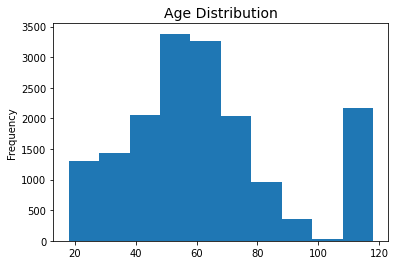

In [14]:
# age distribution
profile.age.plot.hist()
plt.title('Age Distribution', fontsize = 14)

In [15]:
profile.age[profile.age>=100].value_counts() 
# age outliers. guess all the customers who did not input income and gender are filled with age = 118
# set them to null then impute them with median age

118    2175
100      12
101       5
Name: age, dtype: int64

Text(0.5, 1.0, 'Gender Distribution')

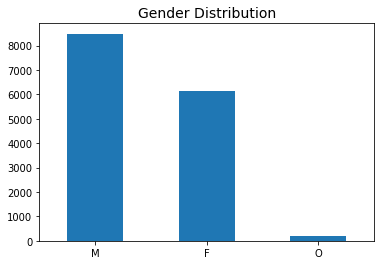

In [16]:
# gender distribution
profile.gender.value_counts().plot.bar(rot=0)
plt.title('Gender Distribution', fontsize = 14)

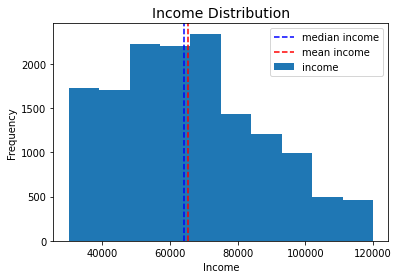

In [17]:
# income distribution
profile.income.plot.hist()
plt.axvline(profile['income'].median(), color = 'blue', linestyle = '--', label = 'median income')
plt.axvline(profile['income'].mean(), color = 'red', linestyle = '--', label = 'mean income')
plt.title('Income Distribution', fontsize = 14)
plt.xlabel('Income')
plt.legend()

## 1.3 Transcript Dataset

In [18]:
transcript

person           event  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer received   
1       a03223e636434f42ac4c3df47e8bac43  offer received   
2       e2127556f4f64592b11af22de27a7932  offer received   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4       68617ca6246f4fbc85e91a2a49552598  offer received   
...                                  ...             ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   
306531  a00058cf10334a308c68e7631c529907     transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   

                                                   value  time  
0       {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3       {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4       {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
...                                                  ...   ...  
306529                    {'amount': 1.5899999999999999}   714  
306530                                  {'amount': 9.53}   714  
306531                                  {'amount': 3.61}   714  
306532                    {'amount': 3.5300000000000002}   714  
306533                                  {'amount': 4.05}   714  

[306534 rows x 4 columns]

In [19]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
# value col is json format, what are diff key value pairs?
value_keys = []
for i in range(transcript.shape[0]):
    if transcript.value[i].keys() not in value_keys:
        value_keys.append(transcript.value[i].keys())
value_keys

[dict_keys(['offer id']),
 dict_keys(['amount']),
 dict_keys(['offer_id', 'reward'])]

Value column in transcript dataset contain dictionary inside the column, so we need to extract all the values in the cleaning process in next section.

# 2. Data Preprocessing

## 2.1 Dataset Preaparing
### a) Portfolio data

In [22]:
df1 = portfolio.copy()

In [23]:
df1

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                           offer_id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

### b) Profile data

In [24]:
df2 = profile.copy()
df2['became_member_on'] = pd.to_datetime(df2['became_member_on'], format='%Y%m%d')

last_date = df2['became_member_on'].max()
df2['memberships_day'] = (last_date - df2['became_member_on']).dt.days

df2 = df2.rename(columns={'id':'customer_id'})

df2.age[df2.age==118] = np.nan

# impute missing age, income, gender
median_age = profile.age.median()
median_income = profile.income.median()


df2['age'] = df2.age.fillna(median_age)
df2['income'] = df2.income.fillna(median_income)

# df2['gender'] = df2.gender.fillna(np.nan).replace([None], 'O')
# df2 = df2.drop(df2[df2['gender'].isnull()].index)


C:\Users\Phongsapon\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [25]:
df2

gender   age                       customer_id became_member_on  \
0       None  58.0  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12   
1          F  55.0  0610b486422d4921ae7d2bf64640c50b       2017-07-15   
2       None  58.0  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12   
3          F  75.0  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09   
4       None  58.0  a03223e636434f42ac4c3df47e8bac43       2017-08-04   
...      ...   ...                               ...              ...   
16995      F  45.0  6d5f3a774f3d4714ab0c092238f3a1d7       2018-06-04   
16996      M  61.0  2cb4f97358b841b9a9773a7aa05a9d77       2018-07-13   
16997      M  49.0  01d26f638c274aa0b965d24cefe3183f       2017-01-26   
16998      F  83.0  9dc1421481194dcd9400aec7c9ae6366       2016-03-07   
16999      F  62.0  e4052622e5ba45a8b96b59aba68cf068       2017-07-22   

         income  memberships_day  
0       64000.0              529  
1      112000.0              376  
2       64000.0               14  
3      100000.0              443  
4       64000.0              356  
...         ...              ...  
16995   54000.0               52  
16996   72000.0               13  
16997   73000.0              546  
16998   50000.0              871  
16999   82000.0              369  

[17000 rows x 6 columns]

Text(0.5, 1.0, 'Gender Distribution')

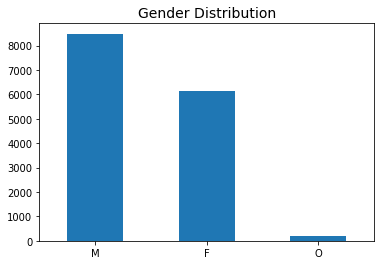

In [26]:
# gender distribution
df2.gender.value_counts().plot.bar(rot=0)
plt.title('Gender Distribution', fontsize = 14)

### c) Transcript data

In [27]:
df3 = transcript.copy()
df3.event = df3.event.str.replace(' ', '_')
df3 = df3.rename(columns={'person':'customer_id'})

df3 = pd.concat([df3, df3['value'].apply(pd.Series)], axis=1)

df3['day'] = df3['time']/24

df3.drop(columns=['value'],inplace = True)

In [28]:
df3['offer_id_new']=np.where(df3['offer id'].isnull() & df3['offer_id'].notnull(),df3['offer_id'],df3['offer id'])

#drop unnecessary offer_id columns
df3.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
df3.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [29]:
df3.head()

customer_id           event  time  amount  reward  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer_received     0     NaN     NaN   
1  a03223e636434f42ac4c3df47e8bac43  offer_received     0     NaN     NaN   
2  e2127556f4f64592b11af22de27a7932  offer_received     0     NaN     NaN   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer_received     0     NaN     NaN   
4  68617ca6246f4fbc85e91a2a49552598  offer_received     0     NaN     NaN   

   day                          offer_id  
0  0.0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1  0.0  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2  0.0  2906b810c7d4411798c6938adc9daaa5  
3  0.0  fafdcd668e3743c1bb461111dcafc2a4  
4  0.0  4d5c57ea9a6940dd891ad53e9dbe8da0

### d) Merged Datasets (transcript & portfolio)

In [30]:
#Merge Transcript & Portfolio
df = pd.merge(df3,df1, how='left',on='offer_id')

df

customer_id           event  time  amount  \
0       78afa995795e4d85b5d9ceeca43f5fef  offer_received     0     NaN   
1       a03223e636434f42ac4c3df47e8bac43  offer_received     0     NaN   
2       e2127556f4f64592b11af22de27a7932  offer_received     0     NaN   
3       8ec6ce2a7e7949b1bf142def7d0e0586  offer_received     0     NaN   
4       68617ca6246f4fbc85e91a2a49552598  offer_received     0     NaN   
...                                  ...             ...   ...     ...   
306529  b3a1272bc9904337b331bf348c3e8c17     transaction   714    1.59   
306530  68213b08d99a4ae1b0dcb72aebd9aa35     transaction   714    9.53   
306531  a00058cf10334a308c68e7631c529907     transaction   714    3.61   
306532  76ddbd6576844afe811f1a3c0fbb5bec     transaction   714    3.53   
306533  c02b10e8752c4d8e9b73f918558531f7     transaction   714    4.05   

        reward_x    day                          offer_id  reward_y  \
0            NaN   0.00  9b98b8c7a33c4b65b9aebfe6a799e6d9       5.0   
1            NaN   0.00  0b1e1539f2cc45b7b9fa7c272da2e1d7       5.0   
2            NaN   0.00  2906b810c7d4411798c6938adc9daaa5       2.0   
3            NaN   0.00  fafdcd668e3743c1bb461111dcafc2a4       2.0   
4            NaN   0.00  4d5c57ea9a6940dd891ad53e9dbe8da0      10.0   
...          ...    ...                               ...       ...   
306529       NaN  29.75                               NaN       NaN   
306530       NaN  29.75                               NaN       NaN   
306531       NaN  29.75                               NaN       NaN   
306532       NaN  29.75                               NaN       NaN   
306533       NaN  29.75                               NaN       NaN   

                            channels  difficulty  duration offer_type  
0               [web, email, mobile]         5.0       7.0       bogo  
1                       [web, email]        20.0      10.0   discount  
2               [web, email, mobile]        10.0       7.0   discount  
3       [web, email, mobile, social]        10.0      10.0   discount  
4       [web, email, mobile, social]        10.0       5.0       bogo  
...                              ...         ...       ...        ...  
306529                           NaN         NaN       NaN        NaN  
306530                           NaN         NaN       NaN        NaN  
306531                           NaN         NaN       NaN        NaN  
306532                           NaN         NaN       NaN        NaN  
306533                           NaN         NaN       NaN        NaN  

[306534 rows x 12 columns]

In [31]:
df.rename(columns={'reward_x':'reward_received', 'reward_y':'reward_defined'},inplace=True)

df.reward_received.value_counts()

5.0     12070
2.0      9334
10.0     7019
3.0      5156
Name: reward_received, dtype: int64

In [32]:
df.groupby(['offer_type','event'])['customer_id'].count()


offer_type     event          
bogo           offer_completed    15669
               offer_received     30499
               offer_viewed       25449
discount       offer_completed    17910
               offer_received     30543
               offer_viewed       21445
informational  offer_received     15235
               offer_viewed       10831
Name: customer_id, dtype: int64


We can observe that the BOGO and discount offer have an offer completed event when offers are completed. However, informational offers do not have this event associated with it. Thus,

1) For BOGO and discount offer, an effective offer is one if the following events are recorded in the right sequence in time:

offer received -> offer viewed -> transaction -> offer completed

2) For an informational offer, effective offer:

offer received -> offer viewed -> transaction

# 2.2 Feature Engineering

## Defining Customer data

### Define all our customers into 2 main groups:

1. People who are influenced and successfully complete - effective offers:

- `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
- `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

2. People who not completed offer recieved following sequence above - ineffective offers:

  2.1) People who received and viewed an offer but did not successfully complete:

    - `offer received` -> `offer viewed`
    
  2.3) People who purchase/complete offers regardless of awareness of any offers:
    
    - `transaction`
    - `offer received` -> `transaction` -> `offer completed` -> `offer viewed`
    - `transaction` -> `offer received` -> `offer completed` -> `offer viewed`
    - `offer received` -> `transaction` -> `offer viewed` -> `offer completed`
    - `offer received` -> `transaction` (informational offers)
    - `offer received` -> `transaction` -> `offer viewed` (informational offers)

  2.4) People who received offers but no action taken:
    
    - `offer received`


### Defining the target variable effective offer on different offer group (Y):

Group 1 customers will be our target variable "effective_offer" = 1 and Group 2 will be considered as ineffective offer which is "effective_offer" = 0 since the offer viewed ordered after the transaction step or did not occur at all.

- 1) bogo_offer: if user have "offer completed" event after viewing for BOGO then 1 else 0
- 2) discount_offer: if user have "offer completed" event after viewing for Discount then 1 else 0
- 3) information_offer: if user have "transaction" event after viewing for informational then 1 else 0

### Defining the features in the ML model (X):
- 1) bogo_off_received, info_off_received, discount_off_received - No. of time each offer type received
- 2) total_trans_cnt -> total transaction count
- 3) total_trans_amt -> total transaction amount
- 4) total_rewards_received -> sum of rewards received from all offers
- 5) avg_trans_amt -> average transaction amount (total_trans_amt/total_trans_cnt)
- 6) trans_cnt_no_offer -> transaction times without any offer 
- 7) trans_cnt_offer -> transactoin times with an offer completion
- 8) trans_amt_offer -> total transaction amount with an offer completion event
- 9) offer_trans_cnt_ratio -> transactoin times with an offer completion/total transaction count
- 10) offer_trans_amt_ratio ->  total transaction amount with an offer completion event/ total transaction amount 
- 11) off_comp_view_ratio -> number of offer completed/ number of offer viewed
- 12) off_comp_receive_ratio -> number of offer completed/ number of offer received
- 13) trans_amt_per_offer ->  total transaction amount with offer/ transaction count with offer
- 14) reward_per_offer -> total rewards received/number of offer completed

In [33]:
user_df = pd.DataFrame(index = profile.id)

#Using unstack to create columns from groupby
offer_type_received = df.loc[df['event']=='offer_received'].groupby('customer_id').offer_type.value_counts().unstack()

user_df = user_df.join(offer_type_received)
user_df.rename(columns={'bogo':'bogo_off_received','discount':'discount_off_received','informational':'info_off_received'},inplace=True)
user_df.head()

bogo_off_received  discount_off_received  \
id                                                                           
68be06ca386d4c31939f3a4f0e3dd783                NaN                    5.0   
0610b486422d4921ae7d2bf64640c50b                1.0                    NaN   
38fe809add3b4fcf9315a9694bb96ff5                1.0                    NaN   
78afa995795e4d85b5d9ceeca43f5fef                3.0                    NaN   
a03223e636434f42ac4c3df47e8bac43                NaN                    3.0   

                                  info_off_received  
id                                                   
68be06ca386d4c31939f3a4f0e3dd783                NaN  
0610b486422d4921ae7d2bf64640c50b                1.0  
38fe809add3b4fcf9315a9694bb96ff5                1.0  
78afa995795e4d85b5d9ceeca43f5fef                1.0  
a03223e636434f42ac4c3df47e8bac43                2.0

In [34]:
total_trans_cnt = df.loc[df['event']=='transaction',:].groupby('customer_id').event.count()
total_trans_amt = df.loc[df['event']=='transaction',:].groupby('customer_id').amount.sum()
total_rewards_received = df.groupby('customer_id').reward_received.sum()


total_recv_cnt = df.loc[df['event']=='offer_received',:].groupby('customer_id').event.count() 
total_view_cnt = df.loc[df['event']=='offer_viewed',:].groupby('customer_id').event.count() 


avg_difficulty = df.groupby('customer_id').difficulty.mean()
avg_duration = df.groupby('customer_id').duration.mean() 
avg_reward = df.groupby('customer_id').reward_received.mean()



user_df = user_df.join(total_trans_cnt,rsuffix='_total_trans_cnt')
user_df = user_df.join(total_trans_amt,rsuffix='_total_trans_amt')
user_df = user_df.join(total_rewards_received,rsuffix='_total_rewards_received')
user_df = user_df.join(total_recv_cnt,rsuffix='_total_recv_cnt')
user_df = user_df.join(total_view_cnt,rsuffix='_total_view_cnt')

user_df = user_df.join(avg_difficulty,rsuffix='_avg_difficulty')
user_df = user_df.join(avg_duration,rsuffix='_avg_duration')
user_df = user_df.join(avg_reward,rsuffix='_avg_reward')

#Rename Column
user_df.rename(columns={'event':'total_trans_cnt'},inplace=True)
user_df.rename(columns={'amount':'total_trans_amt'},inplace=True)
user_df.rename(columns={'reward_received':'total_rewards_received'},inplace=True)
user_df.rename(columns={'event_total_recv_cnt':'total_recv_cnt'},inplace=True)
user_df.rename(columns={'event_total_view_cnt':'total_view_cnt'},inplace=True)
user_df.rename(columns={'event_total_view_cnt':'total_view_cnt'},inplace=True)
user_df.rename(columns={'difficulty':'avg_difficulty'},inplace=True)
user_df.rename(columns={'duration':'avg_duration'},inplace=True)
user_df.rename(columns={'reward_received_avg_reward':'avg_reward'},inplace=True)



user_df['avg_trans_amt'] = user_df['total_trans_amt']/user_df['total_trans_cnt']
user_df['trans_recv_ratio'] = user_df['total_trans_cnt']/user_df['total_recv_cnt']
user_df['trans_view_ratio'] = user_df['total_view_cnt']/user_df['total_recv_cnt']

user_df

bogo_off_received  discount_off_received  \
id                                                                           
68be06ca386d4c31939f3a4f0e3dd783                NaN                    5.0   
0610b486422d4921ae7d2bf64640c50b                1.0                    NaN   
38fe809add3b4fcf9315a9694bb96ff5                1.0                    NaN   
78afa995795e4d85b5d9ceeca43f5fef                3.0                    NaN   
a03223e636434f42ac4c3df47e8bac43                NaN                    3.0   
...                                             ...                    ...   
6d5f3a774f3d4714ab0c092238f3a1d7                1.0                    1.0   
2cb4f97358b841b9a9773a7aa05a9d77                1.0                    NaN   
01d26f638c274aa0b965d24cefe3183f                NaN                    1.0   
9dc1421481194dcd9400aec7c9ae6366                3.0                    NaN   
e4052622e5ba45a8b96b59aba68cf068                1.0                    1.0   

                                  info_off_received  total_trans_cnt  \
id                                                                     
68be06ca386d4c31939f3a4f0e3dd783                NaN              9.0   
0610b486422d4921ae7d2bf64640c50b                1.0              3.0   
38fe809add3b4fcf9315a9694bb96ff5                1.0              6.0   
78afa995795e4d85b5d9ceeca43f5fef                1.0              7.0   
a03223e636434f42ac4c3df47e8bac43                2.0              3.0   
...                                             ...              ...   
6d5f3a774f3d4714ab0c092238f3a1d7                1.0              7.0   
2cb4f97358b841b9a9773a7aa05a9d77                2.0              7.0   
01d26f638c274aa0b965d24cefe3183f                2.0              8.0   
9dc1421481194dcd9400aec7c9ae6366                NaN             14.0   
e4052622e5ba45a8b96b59aba68cf068                2.0              6.0   

                                  total_trans_amt  total_rewards_received  \
id                                                                          
68be06ca386d4c31939f3a4f0e3dd783            20.40                     5.0   
0610b486422d4921ae7d2bf64640c50b            77.01                     5.0   
38fe809add3b4fcf9315a9694bb96ff5            14.30                     0.0   
78afa995795e4d85b5d9ceeca43f5fef           159.27                    20.0   
a03223e636434f42ac4c3df47e8bac43             4.65                     0.0   
...                                           ...                     ...   
6d5f3a774f3d4714ab0c092238f3a1d7            20.03                     0.0   
2cb4f97358b841b9a9773a7aa05a9d77            25.97                     5.0   
01d26f638c274aa0b965d24cefe3183f            39.74                     0.0   
9dc1421481194dcd9400aec7c9ae6366           189.67                    25.0   
e4052622e5ba45a8b96b59aba68cf068           143.02                     8.0   

                                  total_recv_cnt  total_view_cnt  \
id                                                                 
68be06ca386d4c31939f3a4f0e3dd783             5.0             5.0   
0610b486422d4921ae7d2bf64640c50b             2.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             2.0             2.0   
78afa995795e4d85b5d9ceeca43f5fef             4.0             4.0   
a03223e636434f42ac4c3df47e8bac43             5.0             3.0   
...                                          ...             ...   
6d5f3a774f3d4714ab0c092238f3a1d7             3.0             3.0   
2cb4f97358b841b9a9773a7aa05a9d77             3.0             1.0   
01d26f638c274aa0b965d24cefe3183f             3.0             1.0   
9dc1421481194dcd9400aec7c9ae6366             3.0             3.0   
e4052622e5ba45a8b96b59aba68cf068             4.0             2.0   

                                  avg_difficulty  avg_duration  avg_reward  \
id                                                                           
68be06ca386d4c31939f3a4f0e3dd783       

In [35]:
# sort the events by person and time
df = df.sort_values(['customer_id','time'])
df.update(df.groupby(['customer_id']).ffill())
df

customer_id            event  time  amount  \
55972   0009655768c64bdeb2e877511632db8f   offer_received   168     NaN   
77705   0009655768c64bdeb2e877511632db8f     offer_viewed   192     NaN   
89291   0009655768c64bdeb2e877511632db8f      transaction   228   22.16   
113605  0009655768c64bdeb2e877511632db8f   offer_received   336   22.16   
139992  0009655768c64bdeb2e877511632db8f     offer_viewed   372   22.16   
...                                  ...              ...   ...     ...   
258361  ffff82501cea40309d5fdd7edcca4a07      transaction   576   14.23   
258362  ffff82501cea40309d5fdd7edcca4a07  offer_completed   576   14.23   
262475  ffff82501cea40309d5fdd7edcca4a07     offer_viewed   582   14.23   
274809  ffff82501cea40309d5fdd7edcca4a07      transaction   606   10.12   
289924  ffff82501cea40309d5fdd7edcca4a07      transaction   648   18.91   

        reward_received    day                          offer_id  \
55972               NaN   7.00  5a8bc65990b245e5a138643cd4eb9837   
77705               NaN   8.00  5a8bc65990b245e5a138643cd4eb9837   
89291               NaN   9.50  5a8bc65990b245e5a138643cd4eb9837   
113605              NaN  14.00  3f207df678b143eea3cee63160fa8bed   
139992              NaN  15.50  3f207df678b143eea3cee63160fa8bed   
...                 ...    ...                               ...   
258361              5.0  24.00  2906b810c7d4411798c6938adc9daaa5   
258362              2.0  24.00  2906b810c7d4411798c6938adc9daaa5   
262475              2.0  24.25  2906b810c7d4411798c6938adc9daaa5   
274809              2.0  25.25  2906b810c7d4411798c6938adc9daaa5   
289924              2.0  27.00  2906b810c7d4411798c6938adc9daaa5   

        reward_defined                 channels  difficulty  duration  \
55972              0.0  [email, mobile, social]         0.0       3.0   
77705              0.0  [email, mobile, social]         0.0       3.0   
89291              0.0  [email, mobile, social]         0.0       3.0   
113605             0.0     [web, email, mobile]         0.0       4.0   
139992             0.0     [web, email, mobile]         0.0       4.0   
...                ...                      ...         ...       ...   
258361             2.0     [web, email, mobile]        10.0       7.0   
258362             2.0     [web, email, mobile]        10.0       7.0   
262475             2.0     [web, email, mobile]        10.0       7.0   
274809             2.0     [web, email, mobile]        10.0       7.0   
289924             2.0     [web, email, mobile]        10.0       7.0   

           offer_type  
55972   informational  
77705   informational  
89291   informational  
113605  informational  
139992  informational  
...               ...  
258361       discount  
258362       discount  
262475       discount  
274809       discount  
289924       discount  

[306534 rows x 12 columns]

In [36]:
df['event_n-1'] = df.groupby(['customer_id', 'offer_id'])['event'].shift(1)
df['event_n-2'] = df.groupby(['customer_id', 'offer_id'])['event'].shift(2)
df['event_n-3'] = df.groupby(['customer_id', 'offer_id'])['event'].shift(3)

df['effective_offer'] = 0
df['diff'] = 0
df['within_duration'] = 0


bogo = df[df['offer_type']=='bogo']
discount = df[df['offer_type']=='discount']
informational = df[df['offer_type']=='informational']

#BOGO offer
df['effective_offer'].loc[df['offer_type']=='bogo'] = np.where( (bogo['event_n-3']=='offer_received') & (bogo['event_n-2']== 'offer_viewed') & (bogo['event_n-1']== 'transaction') & (bogo['event']== 'offer_completed'),1,0)

#Discount offer
df['effective_offer'].loc[df['offer_type']=='discount'] = np.where( (discount['event_n-3']=='offer_received') & (discount['event_n-2']== 'offer_viewed') & (discount['event_n-1']== 'transaction') & (discount['event']== 'offer_completed'),1,0)

#Informational offer with duration
informational['diff'] = informational[((informational['event']=='offer_received') | (informational['event']=='transaction'))].groupby(['customer_id','offer_id'])['day'].diff()
informational['diff'] = informational.groupby(['customer_id','offer_id'])['diff'].cumsum()
informational['within_duration'] = np.where(informational['diff'] <= informational['duration'],1,0)
informational['effective_offer'] = np.where( (informational['within_duration'] == 1) & (informational['event_n-2']== 'offer_received') & (informational['event_n-1']== 'offer_viewed') & (informational['event']== 'transaction'),1,0)
informational['effective_offer'] = np.where( (informational['event_n-1']== 'transaction') & (informational['event']== 'transaction'),1,informational['effective_offer'])

df.loc[df['offer_type']=='informational']= informational
df

C:\Users\Phongsapon\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\Phongsapon\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Phongsapon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

customer_id            event  time  amount  \
55972   0009655768c64bdeb2e877511632db8f   offer_received   168     NaN   
77705   0009655768c64bdeb2e877511632db8f     offer_viewed   192     NaN   
89291   0009655768c64bdeb2e877511632db8f      transaction   228   22.16   
113605  0009655768c64bdeb2e877511632db8f   offer_received   336   22.16   
139992  0009655768c64bdeb2e877511632db8f     offer_viewed   372   22.16   
...                                  ...              ...   ...     ...   
258361  ffff82501cea40309d5fdd7edcca4a07      transaction   576   14.23   
258362  ffff82501cea40309d5fdd7edcca4a07  offer_completed   576   14.23   
262475  ffff82501cea40309d5fdd7edcca4a07     offer_viewed   582   14.23   
274809  ffff82501cea40309d5fdd7edcca4a07      transaction   606   10.12   
289924  ffff82501cea40309d5fdd7edcca4a07      transaction   648   18.91   

        reward_received    day                          offer_id  \
55972               NaN   7.00  5a8bc65990b245e5a138643cd4eb9837   
77705               NaN   8.00  5a8bc65990b245e5a138643cd4eb9837   
89291               NaN   9.50  5a8bc65990b245e5a138643cd4eb9837   
113605              NaN  14.00  3f207df678b143eea3cee63160fa8bed   
139992              NaN  15.50  3f207df678b143eea3cee63160fa8bed   
...                 ...    ...                               ...   
258361              5.0  24.00  2906b810c7d4411798c6938adc9daaa5   
258362              2.0  24.00  2906b810c7d4411798c6938adc9daaa5   
262475              2.0  24.25  2906b810c7d4411798c6938adc9daaa5   
274809              2.0  25.25  2906b810c7d4411798c6938adc9daaa5   
289924              2.0  27.00  2906b810c7d4411798c6938adc9daaa5   

        reward_defined                 channels  difficulty  duration  \
55972              0.0  [email, mobile, social]         0.0       3.0   
77705              0.0  [email, mobile, social]         0.0       3.0   
89291              0.0  [email, mobile, social]         0.0       3.0   
113605             0.0     [web, email, mobile]         0.0       4.0   
139992             0.0     [web, email, mobile]         0.0       4.0   
...                ...                      ...         ...       ...   
258361             2.0     [web, email, mobile]        10.0       7.0   
258362             2.0     [web, email, mobile]        10.0       7.0   
262475             2.0     [web, email, mobile]        10.0       7.0   
274809             2.0     [web, email, mobile]        10.0       7.0   
289924             2.0     [web, email, mobile]        10.0       7.0   

           offer_type        event_n-1        event_n-2        event_n-3  \
55972   informational              NaN              NaN              NaN   
77705   informational   offer_received              NaN              NaN   
89291   informational     offer_viewed   offer_received              NaN   
113605  informational              NaN              NaN              NaN   
139992  informational   offer_received              NaN              NaN   
...               ...              ...              ...              ...   
258361       discount   offer_received      transaction  offer_completed   
258362       discount      transaction   offer_received      transaction   
262475       discount  offer_completed      transaction   offer_received   
274809       discount     offer_viewed  offer_completed      transaction   
289924       discount      transaction     offer_viewed  offer_completed   

        effective_offer  diff  within_duration  
55972                 0   NaN                0  
77705                 0   NaN                0  
89291                 1   2.5                1  
113605                0   NaN                0  
139992                0   NaN                0  
...                 ...   ...              ...  
258361                0   0.0                0  
258362                0   0.0                0  
262475                0   0.0                0  
274809                0   0.0  

In [37]:
df.groupby(['effective_offer','offer_type'])['event'].count()

effective_offer  offer_type   
0                bogo             119063
                 discount         119758
                 informational     33884
1                bogo               8752
                 discount           7550
                 informational     12720
Name: event, dtype: int64

In [38]:
#Calculate and Add features that used complete of effective offers sequences
bogo_comp = df.loc[(df['effective_offer']==1) & (df['offer_type'] == 'bogo')].groupby('customer_id').effective_offer.sum()
discount_comp = df.loc[(df['effective_offer']==1) & (df['offer_type'] == 'discount')].groupby('customer_id').effective_offer.sum()
info_comp = df.loc[(df['effective_offer']==1) & (df['offer_type'] == 'informational')].groupby('customer_id').effective_offer.sum()

offer_comp_cnt = df.loc[df['effective_offer']==1,:].groupby('customer_id').event.count() 

user_df = user_df.join(offer_comp_cnt,rsuffix='_offer_comp_cnt')
user_df = user_df.join(bogo_comp,rsuffix='_bogo_comp')
user_df = user_df.join(discount_comp,rsuffix='_discount_comp')
user_df = user_df.join(info_comp,rsuffix='_info_comp')


#Rename Column
user_df.rename(columns={'event':'offer_comp_cnt'},inplace=True)
user_df.rename(columns={'effective_offer':'bogo_comp'},inplace=True)
user_df.rename(columns={'effective_offer_discount_comp':'discount_comp'},inplace=True)
user_df.rename(columns={'effective_offer_info_comp':'info_comp'},inplace=True)

user_df['bogo_comp'] = np.where(user_df['bogo_comp'] >= 1, 1, 0)
user_df['discount_comp'] = np.where(user_df['discount_comp'] >= 1, 1, 0)
user_df['info_comp'] = np.where(user_df['info_comp'] >= 1, 1, 0)

user_df['comp_recv_ratio'] = user_df['offer_comp_cnt']/user_df['total_recv_cnt']
user_df['comp_view_ratio'] = user_df['offer_comp_cnt']/user_df['total_view_cnt']
user_df['comp_trans_ratio'] = user_df['offer_comp_cnt']/user_df['total_trans_cnt']

user_df

bogo_off_received  discount_off_received  \
id                                                                           
68be06ca386d4c31939f3a4f0e3dd783                NaN                    5.0   
0610b486422d4921ae7d2bf64640c50b                1.0                    NaN   
38fe809add3b4fcf9315a9694bb96ff5                1.0                    NaN   
78afa995795e4d85b5d9ceeca43f5fef                3.0                    NaN   
a03223e636434f42ac4c3df47e8bac43                NaN                    3.0   
...                                             ...                    ...   
6d5f3a774f3d4714ab0c092238f3a1d7                1.0                    1.0   
2cb4f97358b841b9a9773a7aa05a9d77                1.0                    NaN   
01d26f638c274aa0b965d24cefe3183f                NaN                    1.0   
9dc1421481194dcd9400aec7c9ae6366                3.0                    NaN   
e4052622e5ba45a8b96b59aba68cf068                1.0                    1.0   

                                  info_off_received  total_trans_cnt  \
id                                                                     
68be06ca386d4c31939f3a4f0e3dd783                NaN              9.0   
0610b486422d4921ae7d2bf64640c50b                1.0              3.0   
38fe809add3b4fcf9315a9694bb96ff5                1.0              6.0   
78afa995795e4d85b5d9ceeca43f5fef                1.0              7.0   
a03223e636434f42ac4c3df47e8bac43                2.0              3.0   
...                                             ...              ...   
6d5f3a774f3d4714ab0c092238f3a1d7                1.0              7.0   
2cb4f97358b841b9a9773a7aa05a9d77                2.0              7.0   
01d26f638c274aa0b965d24cefe3183f                2.0              8.0   
9dc1421481194dcd9400aec7c9ae6366                NaN             14.0   
e4052622e5ba45a8b96b59aba68cf068                2.0              6.0   

                                  total_trans_amt  total_rewards_received  \
id                                                                          
68be06ca386d4c31939f3a4f0e3dd783            20.40                     5.0   
0610b486422d4921ae7d2bf64640c50b            77.01                     5.0   
38fe809add3b4fcf9315a9694bb96ff5            14.30                     0.0   
78afa995795e4d85b5d9ceeca43f5fef           159.27                    20.0   
a03223e636434f42ac4c3df47e8bac43             4.65                     0.0   
...                                           ...                     ...   
6d5f3a774f3d4714ab0c092238f3a1d7            20.03                     0.0   
2cb4f97358b841b9a9773a7aa05a9d77            25.97                     5.0   
01d26f638c274aa0b965d24cefe3183f            39.74                     0.0   
9dc1421481194dcd9400aec7c9ae6366           189.67                    25.0   
e4052622e5ba45a8b96b59aba68cf068           143.02                     8.0   

                                  total_recv_cnt  total_view_cnt  \
id                                                                 
68be06ca386d4c31939f3a4f0e3dd783             5.0             5.0   
0610b486422d4921ae7d2bf64640c50b             2.0             NaN   
38fe809add3b4fcf9315a9694bb96ff5             2.0             2.0   
78afa995795e4d85b5d9ceeca43f5fef             4.0             4.0   
a03223e636434f42ac4c3df47e8bac43             5.0             3.0   
...                                          ...             ...   
6d5f3a774f3d4714ab0c092238f3a1d7             3.0             3.0   
2cb4f97358b841b9a9773a7aa05a9d77             3.0             1.0   
01d26f638c274aa0b965d24cefe3183f             3.0             1.0   
9dc1421481194dcd9400aec7c9ae6366             3.0             3.0   
e4052622e5ba45a8b96b59aba68cf068             4.0             2.0   

                                  avg_difficulty  avg_duration  ...  \
id                                                              ...   
68be06ca386d4c31939f3a4f0e3dd783       10.916667     

In [39]:
#Merge user_df with profile data to get demographics features for customer
df2_dummy = pd.get_dummies(df2, columns=['gender'])
df2_dummy.index = df2_dummy.customer_id
df2_dummy.drop(['became_member_on','customer_id'],axis=1, inplace=True)
df2_dummy.head()

age    income  memberships_day  gender_F  \
customer_id                                                                   
68be06ca386d4c31939f3a4f0e3dd783  58.0   64000.0              529         0   
0610b486422d4921ae7d2bf64640c50b  55.0  112000.0              376         1   
38fe809add3b4fcf9315a9694bb96ff5  58.0   64000.0               14         0   
78afa995795e4d85b5d9ceeca43f5fef  75.0  100000.0              443         1   
a03223e636434f42ac4c3df47e8bac43  58.0   64000.0              356         0   

                                  gender_M  gender_O  
customer_id                                           
68be06ca386d4c31939f3a4f0e3dd783         0         0  
0610b486422d4921ae7d2bf64640c50b         0         0  
38fe809add3b4fcf9315a9694bb96ff5         0         0  
78afa995795e4d85b5d9ceeca43f5fef         0         0  
a03223e636434f42ac4c3df47e8bac43         0         0

In [40]:
#finalize the features by joining the two dataframes
user_df_final = user_df.join(df2_dummy)
user_df_final = user_df_final.fillna(value=0)
user_df_final

bogo_off_received  discount_off_received  \
id                                                                           
68be06ca386d4c31939f3a4f0e3dd783                0.0                    5.0   
0610b486422d4921ae7d2bf64640c50b                1.0                    0.0   
38fe809add3b4fcf9315a9694bb96ff5                1.0                    0.0   
78afa995795e4d85b5d9ceeca43f5fef                3.0                    0.0   
a03223e636434f42ac4c3df47e8bac43                0.0                    3.0   
...                                             ...                    ...   
6d5f3a774f3d4714ab0c092238f3a1d7                1.0                    1.0   
2cb4f97358b841b9a9773a7aa05a9d77                1.0                    0.0   
01d26f638c274aa0b965d24cefe3183f                0.0                    1.0   
9dc1421481194dcd9400aec7c9ae6366                3.0                    0.0   
e4052622e5ba45a8b96b59aba68cf068                1.0                    1.0   

                                  info_off_received  total_trans_cnt  \
id                                                                     
68be06ca386d4c31939f3a4f0e3dd783                0.0              9.0   
0610b486422d4921ae7d2bf64640c50b                1.0              3.0   
38fe809add3b4fcf9315a9694bb96ff5                1.0              6.0   
78afa995795e4d85b5d9ceeca43f5fef                1.0              7.0   
a03223e636434f42ac4c3df47e8bac43                2.0              3.0   
...                                             ...              ...   
6d5f3a774f3d4714ab0c092238f3a1d7                1.0              7.0   
2cb4f97358b841b9a9773a7aa05a9d77                2.0              7.0   
01d26f638c274aa0b965d24cefe3183f                2.0              8.0   
9dc1421481194dcd9400aec7c9ae6366                0.0             14.0   
e4052622e5ba45a8b96b59aba68cf068                2.0              6.0   

                                  total_trans_amt  total_rewards_received  \
id                                                                          
68be06ca386d4c31939f3a4f0e3dd783            20.40                     5.0   
0610b486422d4921ae7d2bf64640c50b            77.01                     5.0   
38fe809add3b4fcf9315a9694bb96ff5            14.30                     0.0   
78afa995795e4d85b5d9ceeca43f5fef           159.27                    20.0   
a03223e636434f42ac4c3df47e8bac43             4.65                     0.0   
...                                           ...                     ...   
6d5f3a774f3d4714ab0c092238f3a1d7            20.03                     0.0   
2cb4f97358b841b9a9773a7aa05a9d77            25.97                     5.0   
01d26f638c274aa0b965d24cefe3183f            39.74                     0.0   
9dc1421481194dcd9400aec7c9ae6366           189.67                    25.0   
e4052622e5ba45a8b96b59aba68cf068           143.02                     8.0   

                                  total_recv_cnt  total_view_cnt  \
id                                                                 
68be06ca386d4c31939f3a4f0e3dd783             5.0             5.0   
0610b486422d4921ae7d2bf64640c50b             2.0             0.0   
38fe809add3b4fcf9315a9694bb96ff5             2.0             2.0   
78afa995795e4d85b5d9ceeca43f5fef             4.0             4.0   
a03223e636434f42ac4c3df47e8bac43             5.0             3.0   
...                                          ...             ...   
6d5f3a774f3d4714ab0c092238f3a1d7             3.0             3.0   
2cb4f97358b841b9a9773a7aa05a9d77             3.0             1.0   
01d26f638c274aa0b965d24cefe3183f             3.0             1.0   
9dc1421481194dcd9400aec7c9ae6366             3.0             3.0   
e4052622e5ba45a8b96b59aba68cf068             4.0             2.0   

                                  avg_difficulty  avg_duration  ...  \
id                                                              ...   
68be06ca386d4c31939f3a4f0e3dd783       10.916667     

In [41]:
print(user_df_final[['memberships_day','bogo_comp']].groupby('bogo_comp').count()/len(user_df_final))
print(user_df_final[['memberships_day','discount_comp']].groupby('discount_comp').count()/len(user_df_final))
print(user_df_final[['memberships_day','info_comp']].groupby('info_comp').count()/len(user_df_final))

           memberships_day
bogo_comp                 
0                    0.637
1                    0.363
               memberships_day
discount_comp                 
0                     0.671059
1                     0.328941
           memberships_day
info_comp                 
0                 0.664353
1                 0.335647


#### Scatter and Correlation plot

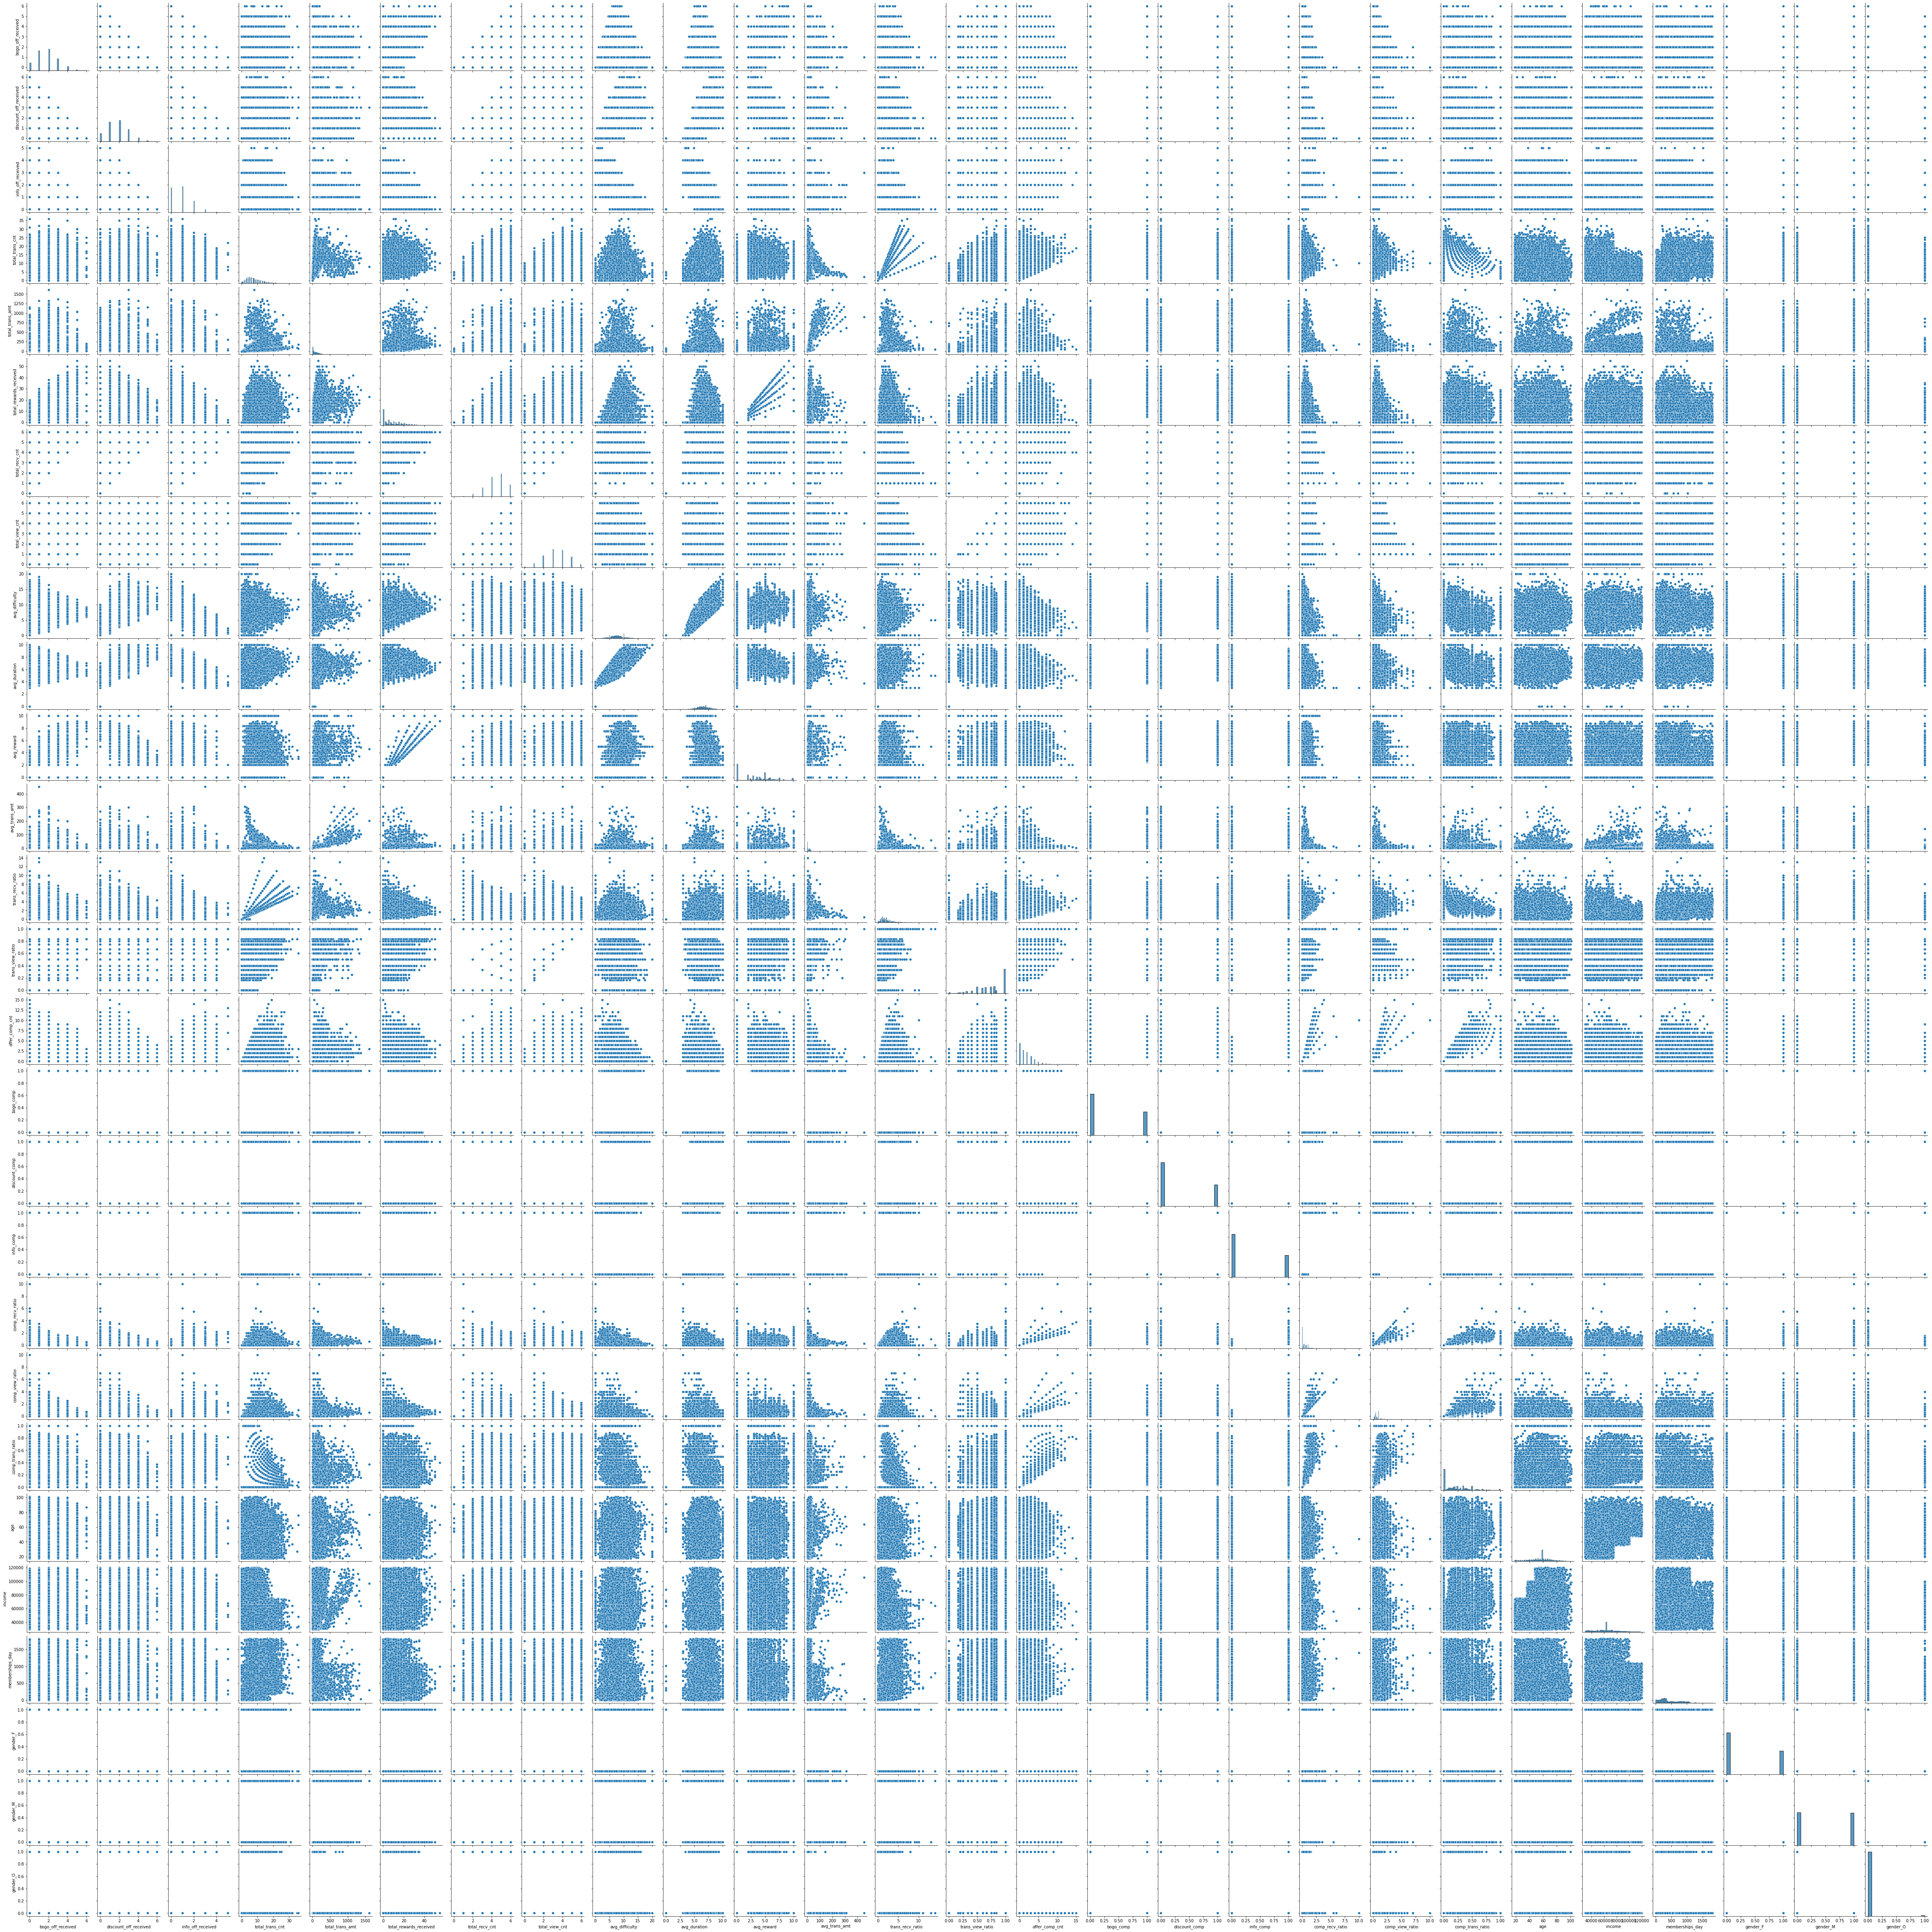

In [42]:
sns.pairplot(user_df_final)   
plt.show()

<AxesSubplot:>

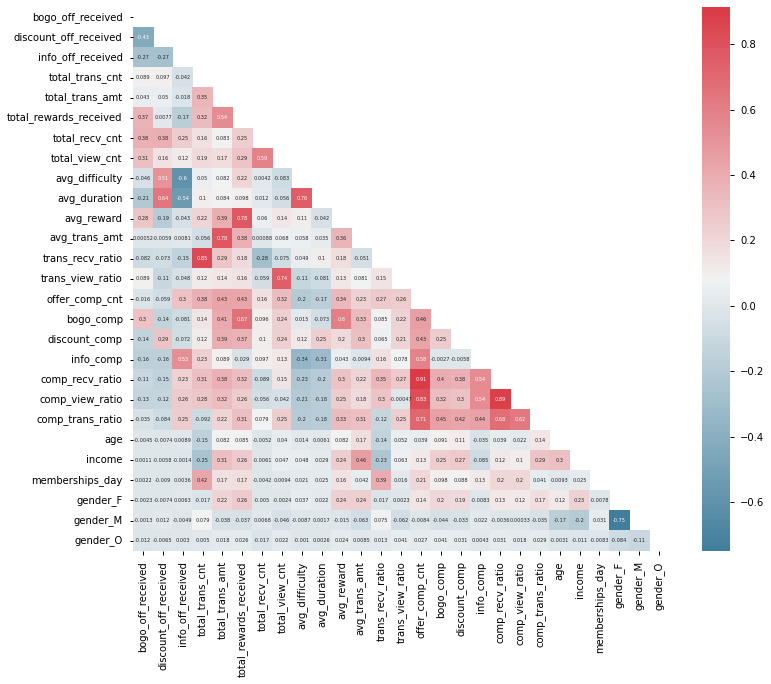

In [43]:
plt.style.use('seaborn-notebook')

corr =user_df_final.corr()

# Set up the matplotlib plot configuration
f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap, annot_kws={"size": 5})

#### Scatterplot of demographics on other features

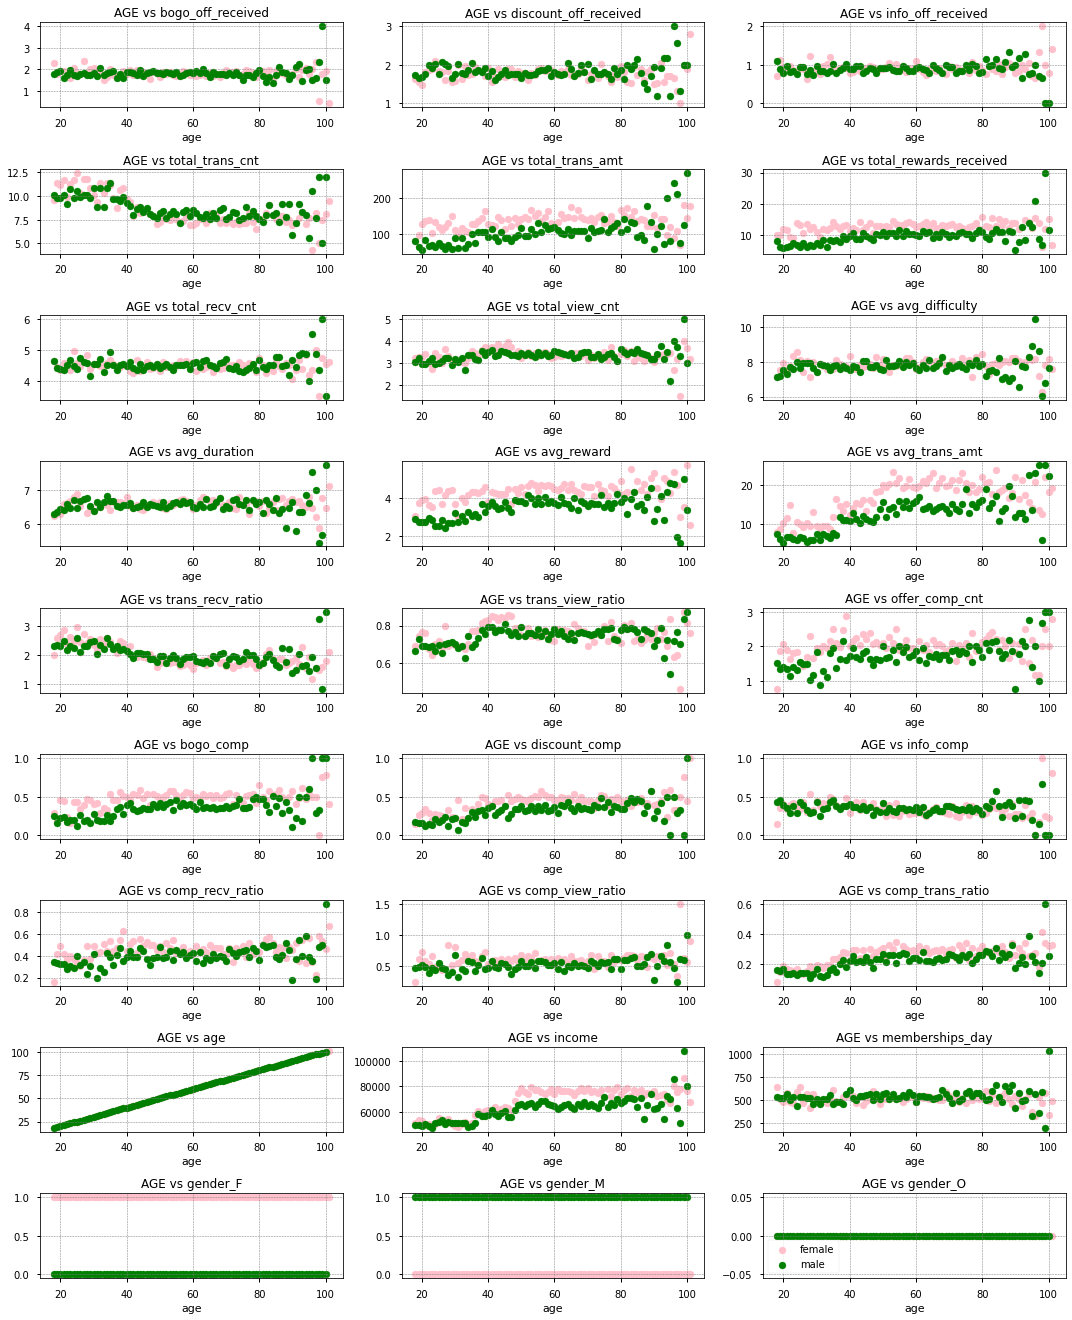

In [44]:
plt.figure(figsize=(15,20))

compare = 'age'

for i,j in enumerate(user_df_final.columns.to_list()):
    
    plt.subplot(10,3,i+1)
    temp1 = user_df_final[user_df_final.gender_F==1].groupby(compare)[j].mean()
    temp2 = user_df_final[user_df_final.gender_M==1].groupby(compare)[j].mean()

    plt.scatter(temp1.index, temp1,color = 'pink');
    plt.scatter(temp2.index, temp2,color = 'green');

    plt.xlabel(compare);
    plt.title(compare.upper() + ' vs ' + j)
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()

plt.legend(['female', 'male'], loc=3);



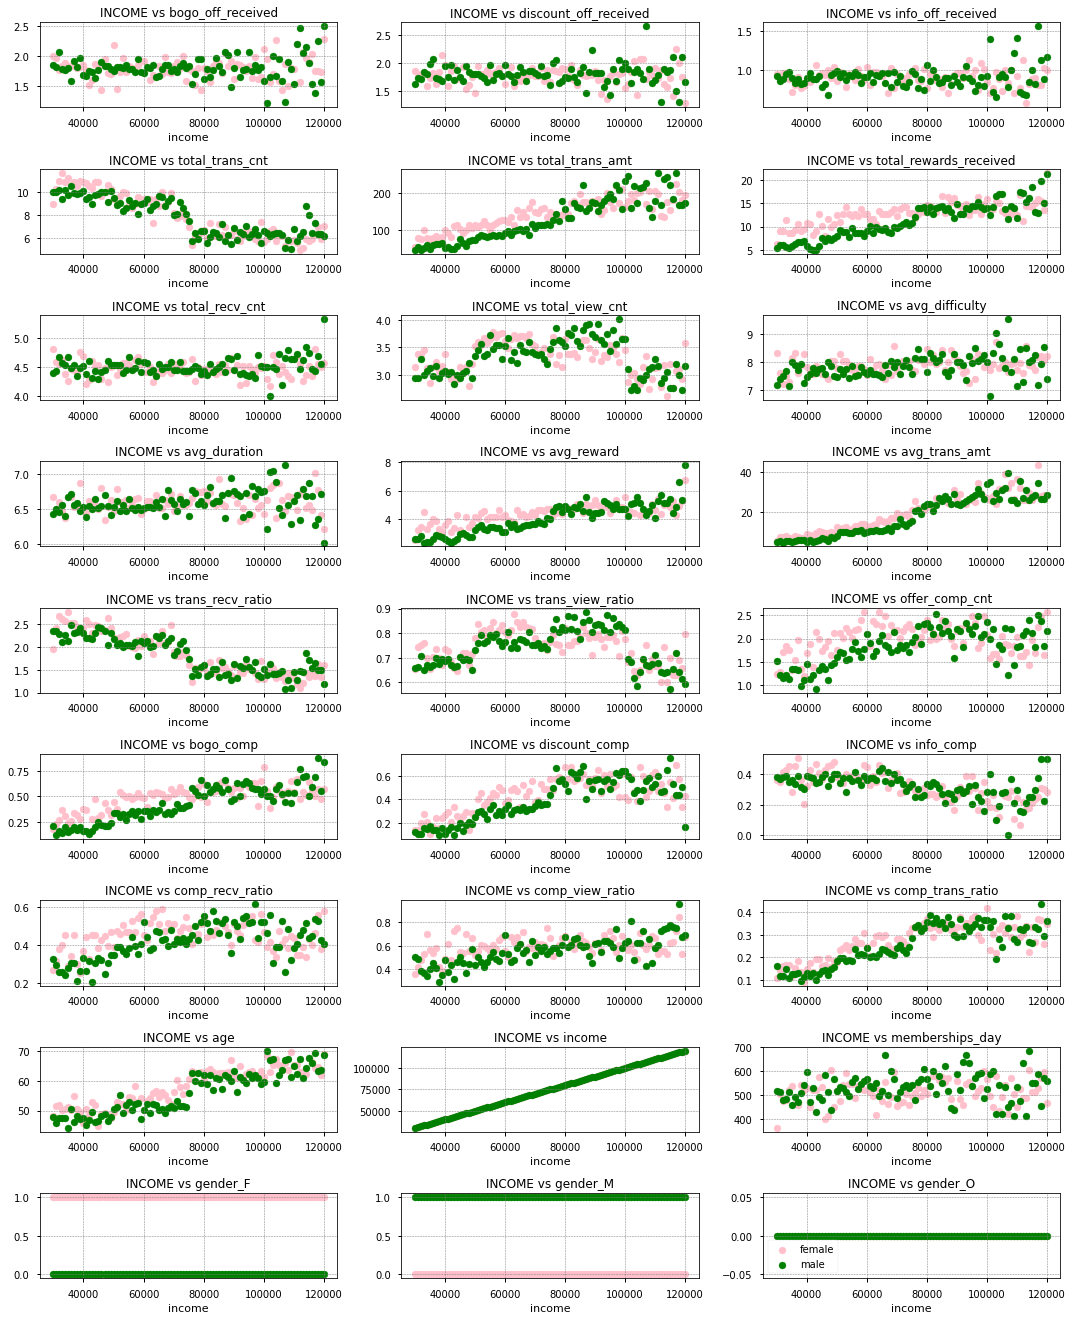

In [45]:
plt.figure(figsize=(15,20))

compare = 'income'

for i,j in enumerate(user_df_final.columns.to_list()):
    
    plt.subplot(10,3,i+1)
    temp1 = user_df_final[user_df_final.gender_F==1].groupby(compare)[j].mean()
    temp2 = user_df_final[user_df_final.gender_M==1].groupby(compare)[j].mean()

    plt.scatter(temp1.index, temp1,color = 'pink');
    plt.scatter(temp2.index, temp2,color = 'green');

    plt.xlabel(compare);
    plt.title(compare.upper() + ' vs ' + j)
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    
    
    plt.tight_layout()

plt.legend(['female', 'male'], loc=3);


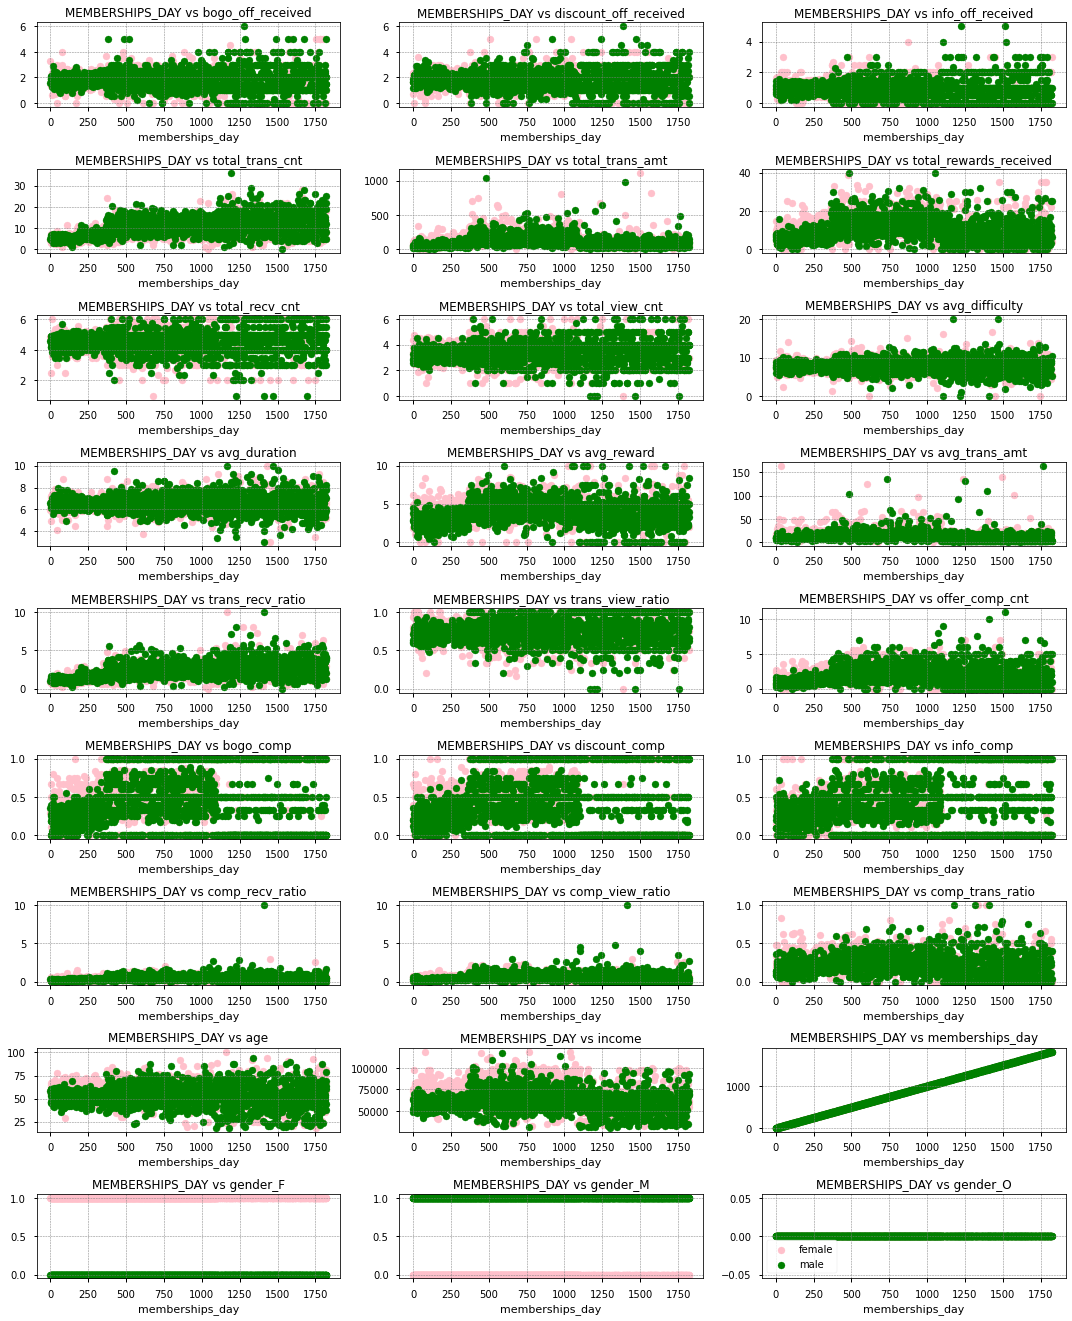

In [46]:

plt.figure(figsize=(15,20))

compare = 'memberships_day'

for i,j in enumerate(user_df_final.columns.to_list()):
    
    plt.subplot(10,3,i+1)
    temp1 = user_df_final[user_df_final.gender_F==1].groupby(compare)[j].mean()
    temp2 = user_df_final[user_df_final.gender_M==1].groupby(compare)[j].mean()

    plt.scatter(temp1.index, temp1,color = 'pink');
    plt.scatter(temp2.index, temp2,color = 'green');

    plt.xlabel(compare);
    plt.title(compare.upper() + ' vs ' + j)
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    
    plt.tight_layout()

plt.legend(['female', 'male'], loc=3);


#### Scatter plot on Demographic summary
- Gender
    - We founded that, from age and income scatterplot, Female customers spent more money to buy products than Male customers and evidences from 'AGE vs total_rewards_received' showed that rewards have influenced Female customers from mostly all age to collect and buy with the offers.

- Age 
    - From observation of the data, customers aged around 20 - 40 years created the most transaction counts and were prone to spend a small amount of money on transactions.

- Income 
    - Income features indicated that customers who have higher income carelessly about offer since INCOME vs total_view_cnt showed that offer view count event reduce with income
    
- Memberships_day
    - Customers who have been in memberships for more than 1200 days (around three years) have offered completion ratio data plotting tightly in the group more than others. There could be labeled as a good or bad offer since customers have a long time in memberships and ratio clustering in more binary type (1 and 0).

# 3. Machine Learning Model

In [47]:
user_df_final.columns

Index(['bogo_off_received', 'discount_off_received', 'info_off_received',
       'total_trans_cnt', 'total_trans_amt', 'total_rewards_received',
       'total_recv_cnt', 'total_view_cnt', 'avg_difficulty', 'avg_duration',
       'avg_reward', 'avg_trans_amt', 'trans_recv_ratio', 'trans_view_ratio',
       'offer_comp_cnt', 'bogo_comp', 'discount_comp', 'info_comp',
       'comp_recv_ratio', 'comp_view_ratio', 'comp_trans_ratio', 'age',
       'income', 'memberships_day', 'gender_F', 'gender_M', 'gender_O'],
      dtype='object')

In [48]:
X = user_df_final.drop(['bogo_comp', 'discount_comp', 'info_comp',], axis=1)
# X = user_df_final.drop(['bogo_comp', 'discount_comp', 'info_comp','offer_comp_cnt','comp_recv_ratio', 'comp_view_ratio', 'comp_trans_ratio'], axis=1)

y = user_df_final[['bogo_comp', 'discount_comp', 'info_comp']]

X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=1, random_state=12 )

clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, oob_score=True))

clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(oob_score=True))

In [49]:
y_pred = clf.predict(X_test)

In [50]:
y_pred_train = clf.predict(X_train)

In [51]:
scores_train = cross_val_score(clf, X_train, y_train, cv=10) 
scores_test = cross_val_score(clf, X_test, y_test, cv=10) 

In [52]:
print("Training accuracy:%.4f" % scores_train.mean())
print("Test accuracy:%.4f" % scores_test.mean())
for i in range(3):
    print(y_test.columns[i])
    print(classification_report(y_test.values[:,i], y_pred[:,i]))


Training accuracy:0.7974
Test accuracy:0.7976
bogo_comp
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3240
           1       0.85      0.92      0.88      1860

    accuracy                           0.91      5100
   macro avg       0.90      0.91      0.90      5100
weighted avg       0.91      0.91      0.91      5100

discount_comp
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3406
           1       0.85      0.87      0.86      1694

    accuracy                           0.91      5100
   macro avg       0.89      0.90      0.90      5100
weighted avg       0.91      0.91      0.91      5100

info_comp
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      3423
           1       0.90      0.92      0.91      1677

    accuracy                           0.94      5100
   macro avg       0.93      0.93      0.93     

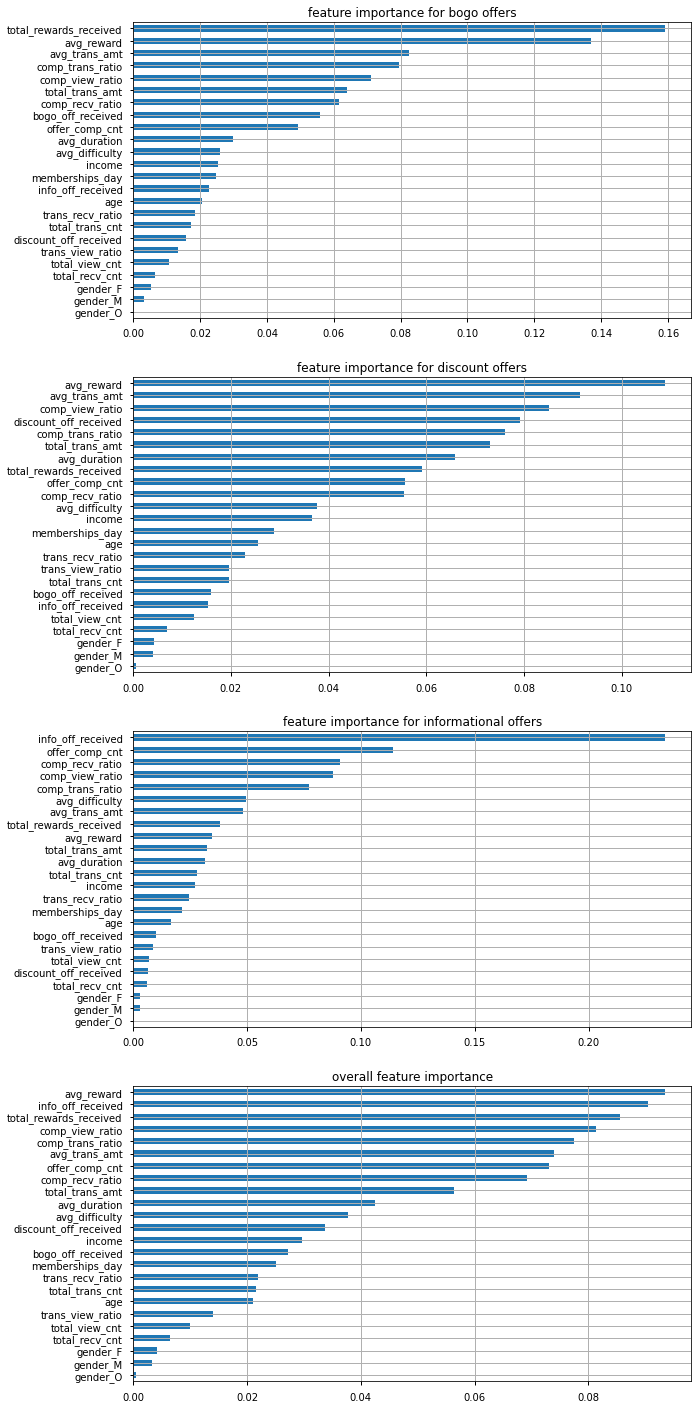

In [53]:
plt.figure(figsize=(10,25))

plt.subplot(4,1,1)
feature_importance_rf = pd.Series(clf.estimators_[0].feature_importances_, index = X_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
plt.title('feature importance for bogo offers')
plt.grid()

plt.subplot(4,1,2)
feature_importance_rf = pd.Series(clf.estimators_[1].feature_importances_, index = X_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
#plt.yticks(fontsize = 10)
plt.title('feature importance for discount offers')
plt.grid()

plt.subplot(4,1,3)
feature_importance_rf = pd.Series(clf.estimators_[2].feature_importances_, index = X_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
plt.title('feature importance for informational offers')
plt.grid()

# overall
feat_impts = [] 
for mod in clf.estimators_:
    feat_impts.append(mod.feature_importances_)
    
plt.subplot(4,1,4)
feature_importance_rf = pd.Series(np.mean(feat_impts, axis=0), index = X_train.columns).sort_values(ascending = True)
feature_importance_rf.plot.barh()
plt.title('overall feature importance')
plt.grid()

### Model Summary
As we can observe on the feature importances, feature 'avg_reward', 'avg_trans_amt' and 'comp_view_ratio' are the most importance from all features. 
- For BOGO offers, it seems like 'avg_reward' and 'total_reward_received' are features that could influences user to buy with the product. 
- For Discount offers, the features that dominance in this are 'avg_tran_amt' and 'avg_reward'. We can infer that based on the price of the products, average amount per transaction could classfy the effective and ineffective one.
- For Infomational offers, 'info_off_received' are the most importance features. Users who tend to receive various of informational offers are likely to complete the transaction. Since this offers does not have 'offer_completed' event, 'avg_reward' feature are not influence user to buy like BOGO and Discount offers.

### 4. User offer Prediction

In [54]:
def best_offer_prediction (customer, model):
    '''
    from list of customer, predict the offers for each customer by predicted probability in descending order.
    '''
    offer_type = ['bogo','discount','informational']
    pred_prob_all = model.predict_proba(X.loc[customer])
    pred_class_all = model.predict(X.loc[customer])
    
    # reorganize the array to get the class 1 predicted probability for each offer for each user
    # result: number of rows = number of users provided, columns = prob of class 1 for each offer type
    pred_prob_new = [[pred_prob_all[c][i][1] for c in range(len(offer_type)) ] for i in range(len(customer))]

    best_offer = []
    no_offer_id =[]
    pred_prob_new = np.array(pred_prob_new)
    
    for user in range(len(pred_prob_new)):
        if pred_class_all[user].sum()>0:
            pred_class1_idx = np.argwhere(pred_class_all[user]==1).flatten() # get the index where predicted offer = 1     
            prob_idx_sorted = np.argsort(-pred_prob_new[user]) # sort probability in descending order
            best_idx = [i for i in prob_idx_sorted if i in pred_class1_idx]
            best_offer.append([offer_type[i] for i in best_idx])
        else:
            best_offer.append('no recommended offer')
            
    return best_offer

In [55]:
customer = np.random.choice(X_test.index, 20)
result = best_offer_prediction(customer, clf)
for i in range(len(customer)):
    user = customer[i]
    print('Recommended offers for {} : {}'.format(user, result[i]))

Recommended offers for 5a7fd20781d64e8baaef972ac4c9e7ce : ['informational', 'discount']
Recommended offers for 49fc32bb19f24c608a04b573d183bf0d : no recommended offer
Recommended offers for 7584948ea6d04f94b8798624706261c2 : ['bogo', 'informational']
Recommended offers for 5d212c185b63411faff45618e357ac9b : ['informational']
Recommended offers for 7864a58fc3da452ab7ec1b5cd230ee15 : no recommended offer
Recommended offers for d5e2f2e2b5be45ed888c42f4997a6a1f : ['bogo', 'discount']
Recommended offers for cdf092b0296c48f1a940e45dc778ddaf : no recommended offer
Recommended offers for 4db19c668503480794c5f97c1a50ae69 : ['discount', 'bogo']
Recommended offers for f900feb23c6949d1aa3e2c6c3cc5c7e5 : ['informational', 'bogo', 'discount']
Recommended offers for 97a351eb00294a7eb63ebdadc0337bdc : ['discount']
Recommended offers for 608952646fc1467ca0b4c385344db80a : ['bogo']
Recommended offers for b818e955451b47db9fc8767fa45e464e : no recommended offer
Recommended offers for dd017e813a984dc5b26bb

# 5. Conclusion 

In conclusion, I found this project fascinating and very challenging, mainly due to the data structure. Preprocessing process of the transcript dataset is a bit tricky to extract all the valuable information of features.

Since my goal of this project is "To predict Which offer(s) that customers tend to have an effective response". Creating a Machine Learning model (RandomForestClassifier) to predict whether a customer will complete an offer by making a transaction after viewing the offer with Multiple Output in the type of offers (BOGO, Discount, and Informational).

According to data exploration on demographic features step, Male and Females almost equally complete the offer but females tend to create more transactions than males especially to collect the rewards. For Income features, it results give a generic outcome with correlates to the number of transactions since customers who have more money tend to spend more on transactions and tend to ignore the offers (not viewed the offers before the transaction).

# 6. Further Improvements

- Creating Recommendation engine that predict specific details of offers type and Make Machine Learning model to predict transaction amount of specific customer. For example: specifics duration, reward for specific user to increase chance of user to buy more product.
- Refining Model with Trial and error on other ML or Using GridSeach for hyperparameter tuning.
- Build Machine Learning Pipeline to seamlessly classify new data.
- Deploy Machine Learning model to web.